In [129]:
import pandas as pd
import numpy as np
import seaborn as sns

from IPython.display import display

%matplotlib inline
pd.set_option('display.max_columns', None)

In [130]:
# Augment Hall of Fame data with name information.

hof_df = pd.read_csv('baseballdatabank-master/core/HallOfFame.csv')
master_df = pd.read_csv('baseballdatabank-master/core/Master.csv')

hof_cols = ['playerID', 'nameFirst', 'nameLast'] + list(hof_df.columns[1:]) 

hof_df = hof_df.merge(master_df, on='playerID')
hof_df = hof_df[hof_cols]

hof_df.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,wagneho01,Honus,Wagner,1936,Veterans,78.0,59.0,5.0,N,Player,NaN
4,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN


In [131]:
# Just want PlayerID and Inducted, remove duplicate No vote records

player_votes = hof_df.loc[(hof_df.category == 'Player')]
inducted_players = hof_df.loc[(hof_df.inducted == 'Y') & (hof_df.category == 'Player')]

non_inducted_ids = set(player_votes.playerID).difference(inducted_players.playerID)

non_inducted_players = player_votes.loc[hof_df.playerID.isin(non_inducted_ids)]
non_inducted_players = non_inducted_players.groupby('playerID', as_index=False).last()

nominated_players = inducted_players.append(non_inducted_players, ignore_index=True)
display(nominated_players.shape)

(1188, 11)

In [132]:
def cumulative_stats(csv_path, display_head=True, agg_dict=None):
    df = pd.read_csv(csv_path)
    
    if display_head == True:
        display(df.head())
    
    df_total = None
    
    if agg_dict is None:
        df_total = df.groupby('playerID', as_index=False).sum()
        del df_total['yearID']
    else:
        df_total = df.groupby('playerID', as_index=False).agg(agg_dict)
    
    return df_total

# Merge with Appearances
appearances_total = cumulative_stats("baseballdatabank-master/core/Appearances.csv")

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,BS1,NaN,barnero01,31.0,NaN,31,31.0,0,0,0,16,0,15,0,0,0,0,NaN,NaN,NaN
1,1871,BS1,NaN,barrofr01,18.0,NaN,18,18.0,0,0,0,1,0,0,13,0,4,17,NaN,NaN,NaN
2,1871,BS1,NaN,birdsda01,29.0,NaN,29,29.0,0,7,0,0,0,0,0,0,27,27,NaN,NaN,NaN
3,1871,BS1,NaN,conefr01,19.0,NaN,19,19.0,0,0,0,0,0,0,18,0,1,18,NaN,NaN,NaN
4,1871,BS1,NaN,gouldch01,31.0,NaN,31,31.0,0,0,30,0,0,0,0,0,1,1,NaN,NaN,NaN


In [133]:
nominated_players = pd.merge(nominated_players, appearances_total, on='playerID')

position_cols = ['G_p','G_c','G_1b','G_2b',
                 'G_3b','G_ss','G_lf','G_cf',
                 'G_rf','G_of','G_dh','G_ph','G_pr']

def most_played_position(df):
    return df[position_cols].idxmax(axis=1).str.split('_').str[1].str.upper()

nominated_players.insert(3, 'Position', most_played_position(nominated_players))
display(nominated_players.head())

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,cobbty01,Ty,Cobb,OF,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN,3034.0,NaN,3034,3034.0,3,0,14,2,1,0,35,2194,706,2934,NaN,NaN,NaN
1,ruthba01,Babe,Ruth,OF,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN,2503.0,NaN,2503,2503.0,163,0,32,0,0,0,1057,64,1131,2241,NaN,NaN,NaN
2,wagneho01,Honus,Wagner,SS,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN,2794.0,NaN,2794,2794.0,2,0,248,57,210,1887,35,67,272,373,NaN,NaN,NaN
3,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN,647.0,NaN,647,647.0,636,0,3,0,0,0,1,0,3,4,NaN,NaN,NaN
4,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN,934.0,NaN,934,934.0,802,0,0,0,0,0,2,7,4,13,NaN,NaN,NaN


In [134]:
# Convert inducted Y/N to numeric for corrplot later
def convert_inducted_to_numeric(s):
    if s == 'Y':
        return 1
    else:
        return 0

nominated_players['inducted'] = nominated_players['inducted'].apply(convert_inducted_to_numeric)

# Pitching

In [135]:
# Merge with Pitching
agg_dict = {'ERA': np.mean, 'W': np.sum}
pitching_total = cumulative_stats("baseballdatabank-master/core/Pitching.csv", 
                                  display_head=False,
                                  agg_dict=agg_dict)

pitchers = nominated_players.loc[nominated_players.Position == 'P']
pitchers = pd.merge(pitchers, pitching_total, on='playerID')

pitchers.head()

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,ERA,W
0,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,1,Player,NaN,647.0,NaN,647,647.0,636,0,3,0,0,0,1,0,3,4,NaN,NaN,NaN,2.648889,373
1,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,1,Player,NaN,934.0,NaN,934,934.0,802,0,0,0,0,0,2,7,4,13,NaN,NaN,NaN,2.348095,417
2,youngcy01,Cy,Young,P,1937,BBWAA,201.0,151.0,153.0,1,Player,NaN,918.0,NaN,918,918.0,906,0,5,0,0,0,0,0,0,0,NaN,NaN,NaN,2.713913,511
3,alexape01,Pete,Alexander,P,1938,BBWAA,262.0,197.0,212.0,1,Player,NaN,703.0,NaN,703,703.0,696,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,2.972381,373
4,wadderu01,Rube,Waddell,P,1946,Old Timers,NaN,NaN,NaN,1,Player,NaN,410.0,NaN,410,410.0,407,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,2.901429,193


In [136]:
def corr_plot(corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 7))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                square=True, xticklabels=corr.columns.values, 
                yticklabels=corr.columns.values,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

    ax.set_title("Correlation plot");

,G_all,ERA,W,inducted
G_all,1.000000,-0.255805,0.297535,0.261107
ERA,-0.255805,1.000000,-0.295432,-0.316926
W,0.297535,-0.295432,1.000000,0.611305
inducted,0.261107,-0.316926,0.611305,1.000000


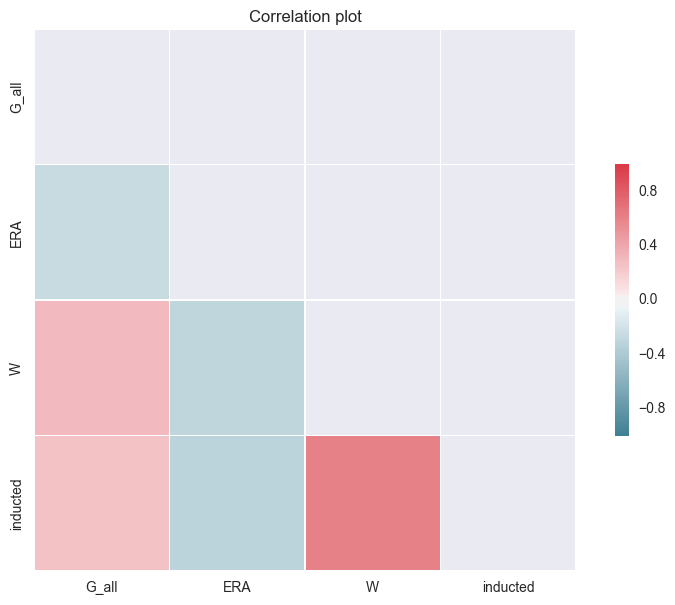

In [137]:
display(pitchers[['G_all', 'ERA', 'W', 'inducted']].corr())
corr_plot(pitchers[['G_all', 'ERA', 'W', 'inducted']].corr())

# Non-Pitchers

In [146]:
def slugging_pct(df):
    return ((df['H'] - df['2B'] - df['3B'] - df['HR']) + 2*df['2B'] + 3*df['3B'] + 4*df['HR']) / df['AB']

def on_base_pct(df):
    return (df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['SF'] + df['HBP'])

def on_base_plus_slugging(df):
    return on_base_pct(df) + slugging_pct(df)

In [156]:
# Merge with Batting
batting_total = cumulative_stats("baseballdatabank-master/core/Batting.csv", 
                                  display_head=False)
non_pitchers = nominated_players.loc[nominated_players.Position != 'P']
non_pitchers = pd.merge(non_pitchers, batting_total, on='playerID')

non_pitchers.fillna(0, inplace=True)

non_pitchers['BA'] = non_pitchers.H / non_pitchers.AB
non_pitchers['SLG'] = slugging_pct(non_pitchers)
non_pitchers['OBP'] = on_base_pct(non_pitchers)
non_pitchers['OPS'] = on_base_plus_slugging(non_pitchers)

non_pitchers.head(20)

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,BA,SLG,OBP,OPS
0,cobbty01,Ty,Cobb,OF,1936,BBWAA,226.0,170.0,222.0,1,Player,0,3034.0,0.0,3034,3034.0,3,0,14,2,1,0,35,2194,706,2934,0.0,0.0,0.0,24,3035,11434.0,2246.0,4189.0,724.0,295.0,117.0,1937.0,892.0,178.0,1249.0,357.0,0.0,94.0,295.0,0.0,0.0,0.366363,0.511982,0.432965,0.944947
1,ruthba01,Babe,Ruth,OF,1936,BBWAA,226.0,170.0,215.0,1,Player,0,2503.0,0.0,2503,2503.0,163,0,32,0,0,0,1057,64,1131,2241,0.0,0.0,0.0,22,2503,8398.0,2174.0,2873.0,506.0,136.0,714.0,2217.0,123.0,117.0,2062.0,1330.0,0.0,43.0,113.0,0.0,2.0,0.342105,0.689807,0.473960,1.163767
2,wagneho01,Honus,Wagner,SS,1936,BBWAA,226.0,170.0,215.0,1,Player,0,2794.0,0.0,2794,2794.0,2,0,248,57,210,1887,35,67,272,373,0.0,0.0,0.0,21,2792,10430.0,1736.0,3415.0,640.0,252.0,101.0,1732.0,722.0,15.0,963.0,327.0,0.0,125.0,221.0,0.0,0.0,0.327421,0.466155,0.390953,0.857109
3,lajoina01,Nap,Lajoie,2B,1937,BBWAA,201.0,151.0,168.0,1,Player,0,2480.0,0.0,2480,2480.0,0,0,286,2035,21,73,4,5,18,26,0.0,0.0,0.0,23,2480,9589.0,1504.0,3242.0,657.0,163.0,83.0,1599.0,380.0,21.0,516.0,85.0,0.0,134.0,221.0,0.0,0.0,0.338096,0.466576,0.380115,0.846692
4,speaktr01,Tris,Speaker,OF,1937,BBWAA,201.0,151.0,165.0,1,Player,0,2789.0,0.0,2789,2789.0,1,0,18,0,0,0,2,2690,6,2698,0.0,0.0,0.0,22,2789,10195.0,1882.0,3514.0,792.0,222.0,117.0,1529.0,432.0,129.0,1381.0,220.0,0.0,103.0,309.0,0.0,0.0,0.344679,0.500343,0.427948,0.928291
5,hornsro01,Rogers,Hornsby,2B,1942,BBWAA,233.0,175.0,182.0,1,Player,0,2259.0,0.0,2259,2259.0,0,0,35,1561,192,356,6,1,13,20,0.0,0.0,0.0,25,2259,8173.0,1579.0,2930.0,541.0,169.0,301.0,1584.0,135.0,64.0,1038.0,679.0,0.0,48.0,216.0,0.0,3.0,0.358497,0.576532,0.433740,1.010273
6,cochrmi01,Mickey,Cochrane,C,1947,BBWAA,161.0,121.0,128.0,1,Player,0,1482.0,0.0,1482,1482.0,0,1451,0,0,0,0,1,0,0,1,0.0,0.0,0.0,13,1482,5169.0,1041.0,1652.0,333.0,64.0,119.0,832.0,64.0,46.0,857.0,217.0,0.0,29.0,151.0,0.0,0.0,0.319598,0.477849,0.419158,0.897006
7,sislege01,George,Sisler,1B,1939,BBWAA,274.0,206.0,235.0,1,Player,0,2055.0,0.0,2055,2055.0,24,0,1971,2,2,0,12,10,15,37,0.0,0.0,0.0,17,2055,8267.0,1284.0,2812.0,425.0,164.0,102.0,1175.0,375.0,127.0,472.0,327.0,0.0,48.0,226.0,0.0,0.0,0.340148,0.468247,0.379197,0.847444
8,collied01,Eddie,Collins,2B,1939,BBWAA,274.0,206.0,213.0,1,Player,0,2826.0,0.0,2826,2826.0,0,0,0,2650,1,40,2,3,5,10,0.0,0.0,0.0,25,2826,9949.0,1821.0,3315.0,438.0,187.0,47.0,1300.0,744.0,173.0,1499.0,286.0,0.0,77.0,512.0,0.0,0.0,0.333199,0.428988,0.424382,0.853370
9,colliji01,Jimmy,Collins,3B,1945,Old Timers,0.0,0.0,0.0,1,Player,0,1725.0,0.0,1725,1725.0,0,0,0,2,1683,6,0,7,21,28,0.0,0.0,0.0,18,1725,6795.0,1055.0,1999.0,352.0,116.0,65.0,983.0,194.0,0.0,426.0,32.0,0.0,84.0,147.0,0.0,0.0,0.294187,0.408830,0.343463,0.752293


In [139]:
list(batting_total.columns)

['playerID',
 'stint',
 'G',
 'AB',
 'R',
 'H',
 '2B',
 '3B',
 'HR',
 'RBI',
 'SB',
 'CS',
 'BB',
 'SO',
 'IBB',
 'HBP',
 'SH',
 'SF',
 'GIDP']

,Games Played,Runs,Runs Batted In,Home Runs,Hits,Stolen Bases,Strike Outs,Batting Average,On-base Percentage,Slugging Average,On-base Plus Slugging,Inducted
G_all,1.000000,0.861047,0.820544,0.575577,0.934841,0.375147,0.578649,0.336887,0.407334,0.399877,0.438649,0.406961
R,0.861047,1.000000,0.841348,0.559531,0.938992,0.546403,0.453176,0.567232,0.559293,0.617900,0.627987,0.545905
RBI,0.820544,0.841348,1.000000,0.801517,0.850516,0.186643,0.589837,0.490910,0.757632,0.534739,0.737863,0.492232
HR,0.575577,0.559531,0.801517,1.000000,0.506334,-0.078652,0.808906,0.151659,0.790185,0.358837,0.695339,0.238761
H,0.934841,0.938992,0.850516,0.506334,1.000000,0.451524,0.435373,0.578296,0.490877,0.510746,0.539385,0.523258
SB,0.375147,0.546403,0.186643,-0.078652,0.451524,1.000000,0.028610,0.267576,-0.029816,0.234519,0.066347,0.263113
SO,0.578649,0.453176,0.589837,0.808906,0.435373,0.028610,1.000000,-0.078079,0.517390,0.152390,0.424471,0.036438
BA,0.336887,0.567232,0.490910,0.151659,0.578296,0.267576,-0.078079,1.000000,0.597648,0.745959,0.703033,0.448893
SLG,0.407334,0.559293,0.757632,0.790185,0.490877,-0.029816,0.517390,0.597648,1.000000,0.671101,0.960955,0.338724
OBP,0.399877,0.617900,0.534739,0.358837,0.510746,0.234519,0.152390,0.745959,0.671101,1.000000,0.850037,0.400916


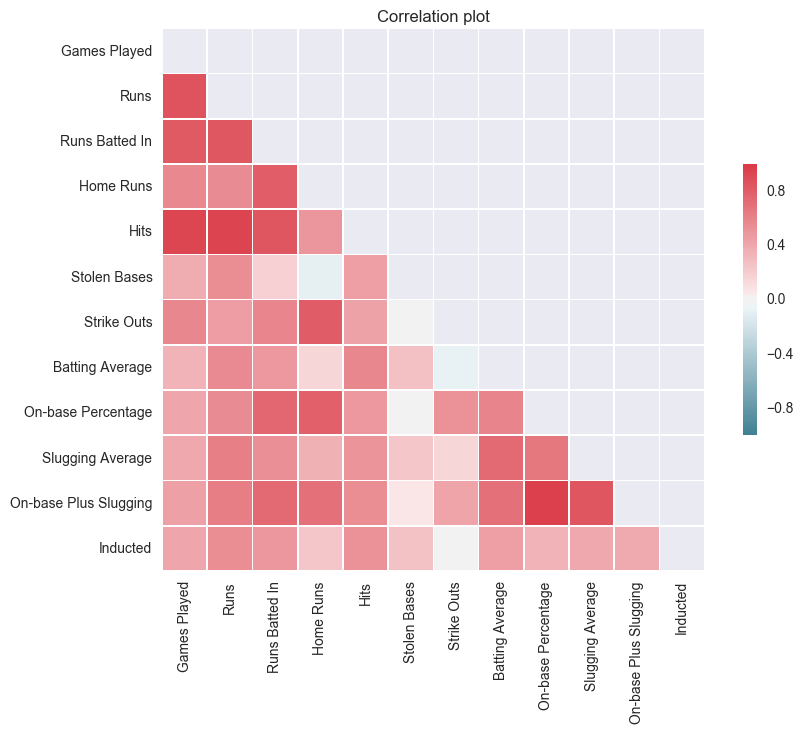

In [157]:
batting_corr = non_pitchers[['G_all', 'R', 'RBI', 'HR', 'H', 'SB', 'SO', 'BA', 'SLG', 'OBP', 'OPS','inducted']].corr()
batting_corr.columns = ['Games Played', 'Runs', 'Runs Batted In', 'Home Runs', 
                        'Hits', 'Stolen Bases', 'Strike Outs', 'Batting Average', 
                        'On-base Percentage', 'Slugging Average', 'On-base Plus Slugging',
                        'Inducted']
display(batting_corr)
corr_plot(batting_corr)

In [141]:
# Merge with Awards